In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv', index_col=0, encoding='utf-8')

data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime

In [4]:
# проверим наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 11809 to 7202
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

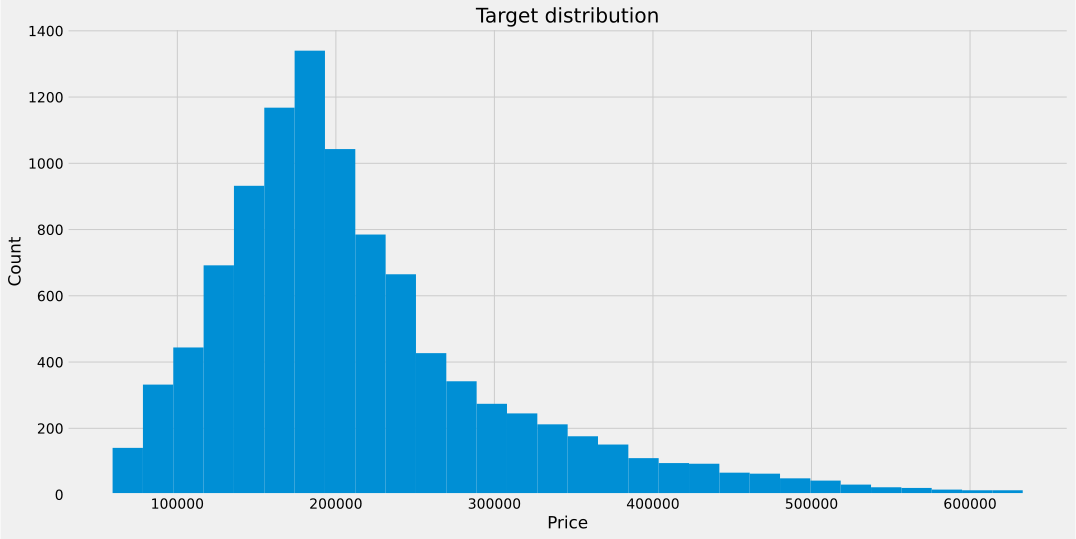

In [5]:
plt.figure(figsize = (16, 8))

data['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [6]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [7]:
# заполним пропуски нулями

cleared_data = data.fillna(0)

In [8]:
X = cleared_data.drop(labels=['Price'], axis=1)
X = pd.get_dummies(data=X, columns=['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], drop_first=True)
y = cleared_data['Price'].values

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [10]:
model_dict = {
   'lr': LinearRegression(),
    'lasso': Lasso(random_state=42),
    'ridge': Ridge(random_state=42),
    'enet': ElasticNet(random_state=42),
   'knn': KNeighborsRegressor(),
   'dt': DecisionTreeRegressor(random_state=42),
   'rf': RandomForestRegressor(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_valid = model_dict[model].predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    score_list.append((score_train, score_valid))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\ttrain: {np.round(scores[0], 4)} \n\tvalid: {np.round(scores[1], 4)}')

lr: 
	train: 0.6573 
	valid: 0.6184
lasso: 
	train: 0.6573 
	valid: 0.6185
ridge: 
	train: 0.6573 
	valid: 0.6184
enet: 
	train: 0.6133 
	valid: 0.4605
knn: 
	train: 0.7467 
	valid: 0.5918
dt: 
	train: 1.0 
	valid: 0.4813
rf: 
	train: 0.962 
	valid: 0.7349


 с минимальной педобработкой данных лучший результат "из коробки" показала модель RandomForest
 baseline R^2 = 0.7349


In [11]:
# очистка данные

cleared_data = data[data['Rooms'] < 10]
cleared_data = cleared_data[cleared_data['Square'] < 250]
cleared_data = cleared_data[cleared_data['HouseFloor'] < 100]

In [12]:
# функция для предобработки данных

def preproc(df_input, dummy_features=None):
    
    df_output = df_input.copy()
        
    Square = dict(df_output.groupby('Rooms')['Square'].median())
    idx = (df_output['Square'] < 15) & (df_output['Rooms'] < 2)
    df_output.loc[idx, 'Square'] = df_output.loc[idx, 'Rooms'].apply(lambda x: Square[x])
    
    idx = (df_output['Square'] < 30) & (df_output['Rooms'] > 1)
    df_output.loc[idx, 'Square'] = df_output.loc[idx, 'Rooms'].apply(lambda x: Square[x])
    
    idx = (df_output['Square'] < df_output['LifeSquare'])
    df_output.loc[idx, 'Square'] = df_output.loc[idx, 'LifeSquare']

    LifeSquare = dict(df_output.groupby('Rooms')['LifeSquare'].median())
    idx = (df_output['LifeSquare'].isnull())
    df_output.loc[idx, 'LifeSquare'] = df_output.loc[idx, 'Rooms'].apply(lambda x: LifeSquare[x])

    idx = (df_output['Rooms'] < 1)
    df_output.loc[idx, 'KitchenSquare'] = 0.0
    
    KitchenSquare = dict(df_output.groupby('Rooms')['KitchenSquare'].median())
    idx = (df_output['Rooms'] > 0)
    df_output.loc[idx, 'KitchenSquare'] = df_output.loc[idx, 'Rooms'].apply(lambda x: KitchenSquare[x])
    
    idx = (df_output['HouseFloor'] < df_output['Floor'])
    df_output.loc[idx, 'HouseFloor'] = df_output.loc[idx, 'Floor']
    
    current_year = datetime.now().year
    idx = (df_output['HouseYear'] >= current_year)
    df_output.loc[idx, 'HouseYear'] = current_year
   
    df_output['Healthcare_1'].fillna(df_output['Healthcare_1'].median(), inplace=True)
    
    df_output['Ecology_2'] = df_output['Ecology_2'].apply(lambda x: 1 if x == 'A' else 0)
    df_output['Ecology_3'] = df_output['Ecology_3'].apply(lambda x: 1 if x == 'A' else 0)
    df_output['Shops_2'] = df_output['Shops_2'].apply(lambda x: 1 if x == 'A' else 0)
    
    if dummy_features != None:
        df_output = pd.get_dummies(data=df_output, columns=dummy_features, drop_first=True)
    
    return df_output

In [13]:
processed_data = preproc(cleared_data, dummy_features=None)

X = processed_data.drop(labels=['DistrictId', 'Price'], axis=1)
y = processed_data['Price'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [14]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [15]:
# настройка гиперпараметров модели с помощью RandomizedSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.7min finished


0.7247368707831973
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 26}


In [16]:
# измерение качества подобранной модели на отложенной выборке

y_pred_train = random_search.best_estimator_.predict(X_train_scaled)
y_pred_valid = random_search.best_estimator_.predict(X_valid_scaled)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_valid, y_pred_valid)

print(f'train: {np.round(score_train, 4)}\nvalid: {np.round(score_valid, 4)}')

train: 0.9382
valid: 0.717


In [17]:
# обучим подобранную модель на всех тренировочных данных

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=26,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_scaled, y)

scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=10, n_jobs=-1)

print(f'cv mean: {np.round(np.mean(scores), 4)}')
print(f'cv std:  {np.round(np.std(scores), 4)}')

cv mean: 0.7333
cv std:  0.0252


In [18]:
# загрузим 'test.csv'

new_data = pd.read_csv('test.csv', index_col=0, encoding='utf-8')

new_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [19]:
# обработка новые данные

processed_new_data = preproc(new_data, dummy_features=None)

X_new = processed_new_data.drop(labels=['DistrictId'], axis=1)

In [20]:
# масштабируем новые данные подготовленным на тренировочных данных объектом класса MinMaxScaler

X_new_scaled = scaler.transform(X_new)

# предскажем цены квартир для новых наблюдений

y_pred_new = model.predict(X_new_scaled)

# запишем id объекта и предсказанную цену в датафрейм

predictions = pd.DataFrame({
    'Id': X_new.index,
    'Price': y_pred_new
})

predictions.head()

,Id,Price
0,4567,157030.434070
1,5925,110884.443932
2,960,138630.490809
3,3848,128503.497926
4,746,226508.854312


In [21]:
predictions.to_csv('vs.csv', sep=',', index=False, encoding='utf-8')